# Credits

This is heavily influenced by [hedgehoglabs/xor](https://github.com/hedgehoglabs/xor).

# Introduction to Recurrent Neural Networks (RNN)

This notebook introduces the concept of Recurrent Neural Networks (RNN).
You won't have as many programming tasks in this exercise, but do make sure that you read everyhing carefully, and understand what is going on.

___

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to the future computation.
An image may best explain how this is to be understood,

![rnn-unroll image](../static_files/rnn-unfold.png)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$

# The Problem of Parity
(parity simply means wheather the number is even or odd)

The exercise comes from the OpenAI [Requests for Research 2.0](https://blog.openai.com/requests-for-research-2/) warmup exercise.
The exercise reads:

> Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:
> 1. Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?
> 1. Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?

LSTM stands for 'Long short-term memory', and is an extension of the standard RNN model described above.
An LSTM has been extended with a memory module that enables it to remember over longer sequences.

In this exercise we will however **stick with a standard RNN instead of an LSTM**.
(The LSTM model will be covered later. See [this excelent blogpost](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah for more on LSTM's.)


## 1. Generating the Data

Before we do much of anything we need some data to work with.
The code below we generate the binary vectors that we will be working with.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
from torch.nn.utils import rnn as rnn_utils
from torch.utils.data import DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
max_bits = 50
batch_size = 8

DEFAULT_NUM_BITS = 50
DEFAULT_NUM_SEQUENCES = 100000

In [2]:
## Functions to load the data set

class XORDataset(data.Dataset):
    def __init__(self, num_sequences=DEFAULT_NUM_SEQUENCES, num_bits=DEFAULT_NUM_BITS):
        self.num_sequences = num_sequences
        self.num_bits = num_bits

        self.features, self.labels = get_random_bits_parity(num_sequences, num_bits)

        # expand the dimensions for the rnn
        # [batch, bits] -> [batch, bits, 1]
        self.features = np.expand_dims(self.features, -1)

        # [batch, parity] -> [batch, parity, 1]
        self.labels = np.expand_dims(self.labels, -1)

    def __getitem__(self, index):
        return self.features[index, :], self.labels[index]

    def __len__(self):
        return len(self.features)


def get_random_bits_parity(num_sequences, num_bits):
    """Generate random bit sequences and their parity. (Our features and labels).
        Returns:
            bit_sequences: A numpy array of bit sequences with shape [num_sequences, num_bits].
            parity: A numpy array of even parity values corresponding to each bit
                with shape [num_sequences, num_bits].
        """
    bit_sequences = np.random.randint(2, size=(num_sequences, num_bits))

    # if total number of ones is odd, set even parity bit to 1, otherwise 0
    # https://en.wikipedia.org/wiki/Parity_bit

#     bitsum = np.sum(bit_sequences, axis=1)  # use only the final result.
    bitsum = np.cumsum(bit_sequences, axis=1)  # Teacher forcing

    # if bitsum is even: False, odd: True
    parity = bitsum % 2 != 0

    return bit_sequences.astype('float32'), parity.astype('float32')

train_loader = DataLoader(XORDataset(num_bits=max_bits), batch_size=batch_size, shuffle=True)

Let's see what it looks like.
In order to make the print statement look nicer we print the transpose of the data - i.e. the data is `[seq_len, num_seq]` here:

In [3]:
for inputs, targets  in train_loader:
    print('inputs')
    print(inputs.numpy()[:,:15].T)
#     print(np.sum(inputs.numpy(), 1).T)
    print()
    print('targets')
    print(targets.numpy()[:,:15].T)
    break

inputs
[[[0. 1. 0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 1. 0. 1. 1. 1.]
  [0. 0. 1. 1. 1. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1.]
  [1. 1. 0. 0. 1. 1. 0. 1.]
  [0. 0. 1. 1. 0. 1. 0. 1.]
  [0. 1. 1. 0. 0. 1. 0. 0.]
  [1. 0. 1. 1. 0. 1. 0. 1.]
  [1. 0. 1. 0. 1. 0. 1. 1.]
  [1. 0. 0. 1. 1. 1. 0. 0.]
  [0. 1. 0. 1. 1. 0. 0. 1.]
  [1. 1. 1. 1. 0. 0. 1. 0.]
  [0. 1. 1. 0. 1. 0. 0. 1.]
  [1. 0. 0. 1. 1. 1. 1. 0.]
  [0. 1. 0. 0. 1. 1. 1. 1.]]]

targets
[[[0. 1. 0. 0. 0. 0. 1. 0.]
  [1. 1. 0. 1. 0. 1. 0. 1.]
  [1. 1. 1. 0. 1. 1. 0. 0.]
  [1. 1. 1. 0. 1. 1. 0. 1.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 1. 0. 1.]
  [0. 1. 1. 1. 0. 0. 0. 1.]
  [1. 1. 0. 0. 0. 1. 0. 0.]
  [0. 1. 1. 0. 1. 1. 1. 1.]
  [1. 1. 1. 1. 0. 0. 1. 1.]
  [1. 0. 1. 0. 1. 0. 1. 0.]
  [0. 1. 0. 1. 1. 0. 0. 0.]
  [0. 0. 1. 1. 0. 0. 0. 1.]
  [1. 0. 1. 0. 1. 1. 1. 1.]
  [1. 1. 1. 0. 0. 0. 0. 0.]]]


Rather than only have a target for the very last element in the sequence, we make a target for every sub-sequence along the way.
During training we use all these targets to help the network learn along the way.



## The RNN Model

One of the nice things with using a library like `PyTorch` is that a lot of the complexity is hidden away.
Creating a RNN is therefore not much different than creating any other kind of network, as we shall see below.
Do however make sure to understand the concepts - they will help you debug, or when you want to work with more advanced concepts.

Things to note however:
 * `batch_first=True` determines the order of the sequence. Normally in `PyTorch` the input is expected to be `[seq_len, batch, input_size]`, but this is sometimes inconvenient, so we use `batch_first=True` to make the input `[batch, seq, feature]`. 
 * `pack_padded_sequence` and `pad_packed_sequence` are used for variable length sequences when the sequences don't have the same length. (Computers don't deal well with sequences of varing length, so we use padding to make them align).
 
For more on RNNs in `PyTorch` [see here](https://pytorch.org/docs/stable/nn.html#torch.nn.RNN).

In [4]:
class RNN(torch.nn.Module):
    def __init__(self, hidden_size, device):
        super().__init__()

        self.rnn = torch.nn.RNN(
                batch_first=True,
                input_size=1,
                hidden_size=hidden_size,
                num_layers=1)

        self.hidden_to_logits = torch.nn.Linear(hidden_size, 1)
        self.activation = torch.nn.Sigmoid()

    def forward(self, inputs, lengths):
        # pack the inputs
        packed_inputs = rnn_utils.pack_padded_sequence(
                inputs, lengths, batch_first=True).to(device)

        rnn_out, _ = self.rnn(packed_inputs)

        unpacked, _ = rnn_utils.pad_packed_sequence(rnn_out, batch_first=True)

        logits = self.hidden_to_logits(unpacked)
        predictions = self.activation(logits)

        return logits, predictions

hidden_size = 4

model = RNN(hidden_size, device).to(device)

As allways we need to define our optimizer and loss function.

In [5]:
lr = 0.1
momentum = 0.9
lr = 1
momentum = 0
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [6]:
## Helper functions - you don't need to worry about them.

def adjust_lengths(vary_lengths, inputs, targets):
    batch_size = inputs.size()[0]
    max_bits = inputs.size()[1]

    if not vary_lengths:
        lengths = torch.ones(batch_size, dtype=torch.int) * max_bits
        return lengths

    # choose random lengths
    lengths = np.random.randint(1, max_bits, size=batch_size, dtype=int)

    # keep one the max size so we don't need to resize targets for the loss
    lengths[0] = max_bits

    # sort in descending order
    lengths = -np.sort(-lengths)

    # chop the bits based on lengths
    for i, sample_length in enumerate(lengths):
        inputs[i, lengths[i]:, ] = 0
        targets[i, lengths[i]:, ] = 0

    return lengths


def evaluate(max_bits, vary_lengths, device, model):
    # evaluate on more bits than training to ensure generalization
    valid_loader = DataLoader(
            XORDataset(num_sequences=5000, num_bits=int(max_bits * 1.5)), batch_size=500)

    is_correct = np.array([])

    for inputs, targets in valid_loader:
        lengths = adjust_lengths(vary_lengths, inputs, targets)
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            logits, predictions = model(inputs, lengths)
            is_correct = np.append(is_correct, ((predictions > 0.5) == (targets > 0.5)))

    accuracy = is_correct.mean()
    return accuracy


## Training the Network

We are now ready to train the network. 
This is also very similar to what we have already seen.

In [9]:
step = 0
epochs = 5
vary_lengths = True

train_accs = []
valid_accs = []

for epoch in range(1, epochs + 1):
    for inputs, targets in train_loader:
        lengths = adjust_lengths(vary_lengths, inputs, targets)
        targets = targets.to(device)
        optimizer.zero_grad()

        logits, predictions = model(inputs, lengths)

        # BCEWithLogitsLoss will do the activation
        loss = loss_fn(logits, targets)

        loss.backward()
        optimizer.step()
        step += 1

        accuracy = ((predictions > 0.5) == (targets > 0.5)).type(torch.FloatTensor).mean()
        train_accs.append((step, accuracy))

        if step % 250 == 0:
            #Note: If you receive an error at the following line, you are not using a Python 3.6.x kernel
            print(f'epoch {epoch:2d}, step {step:5d}. Train summary: loss {loss.item():.{4}f}, accuracy {accuracy:.{3}f}')

        if step % 1000 == 0:
            valid_accuracy = evaluate(max_bits, vary_lengths, device, model)
            valid_accs.append((step, valid_accuracy))
            print(f'Validation accuracy {valid_accuracy:.{3}f}\n')
            if valid_accuracy == 1.0:
                # stop early
                print('Stop early: valid_accuracy == 1.0')
                break
    if valid_accuracy == 1.0: break

epoch  1, step   250. Train summary: loss 0.3868, accuracy 0.707
epoch  1, step   500. Train summary: loss 0.3703, accuracy 0.760
epoch  1, step   750. Train summary: loss 0.3750, accuracy 0.723
epoch  1, step  1000. Train summary: loss 0.4449, accuracy 0.665
Validation accuracy 0.764

epoch  1, step  1250. Train summary: loss 0.4282, accuracy 0.685
epoch  1, step  1500. Train summary: loss 0.2904, accuracy 0.803
epoch  1, step  1750. Train summary: loss 0.4130, accuracy 0.720
epoch  1, step  2000. Train summary: loss 0.4127, accuracy 0.692
Validation accuracy 0.764

epoch  1, step  2250. Train summary: loss 0.3360, accuracy 0.752
epoch  1, step  2500. Train summary: loss 0.3607, accuracy 0.757
epoch  1, step  2750. Train summary: loss 0.3720, accuracy 0.752
epoch  1, step  3000. Train summary: loss 0.3176, accuracy 0.767
Validation accuracy 0.774

epoch  1, step  3250. Train summary: loss 0.3593, accuracy 0.777
epoch  1, step  3500. Train summary: loss 0.3225, accuracy 0.748
epoch  1,

epoch  3, step 29000. Train summary: loss 0.3336, accuracy 0.738
Validation accuracy 0.763

epoch  3, step 29250. Train summary: loss 0.3312, accuracy 0.788
epoch  3, step 29500. Train summary: loss 0.4889, accuracy 0.673
epoch  3, step 29750. Train summary: loss 0.2659, accuracy 0.842
epoch  3, step 30000. Train summary: loss 0.3633, accuracy 0.752
Validation accuracy 0.767

epoch  3, step 30250. Train summary: loss 0.4745, accuracy 0.675
epoch  3, step 30500. Train summary: loss 0.2688, accuracy 0.783
epoch  3, step 30750. Train summary: loss 0.3396, accuracy 0.767
epoch  3, step 31000. Train summary: loss 0.4510, accuracy 0.670
Validation accuracy 0.761

epoch  3, step 31250. Train summary: loss 0.3209, accuracy 0.752
epoch  3, step 31500. Train summary: loss 0.3152, accuracy 0.790
epoch  3, step 31750. Train summary: loss 0.3588, accuracy 0.735
epoch  3, step 32000. Train summary: loss 0.4486, accuracy 0.702
Validation accuracy 0.767

epoch  3, step 32250. Train summary: loss 0.392

epoch  5, step 57500. Train summary: loss 0.3889, accuracy 0.702
epoch  5, step 57750. Train summary: loss 0.2984, accuracy 0.770
epoch  5, step 58000. Train summary: loss 0.3368, accuracy 0.745
Validation accuracy 0.762

epoch  5, step 58250. Train summary: loss 0.3511, accuracy 0.728
epoch  5, step 58500. Train summary: loss 0.3303, accuracy 0.785
epoch  5, step 58750. Train summary: loss 0.2561, accuracy 0.825
epoch  5, step 59000. Train summary: loss 0.2284, accuracy 0.837
Validation accuracy 0.764

epoch  5, step 59250. Train summary: loss 0.3522, accuracy 0.733
epoch  5, step 59500. Train summary: loss 0.3192, accuracy 0.757
epoch  5, step 59750. Train summary: loss 0.3812, accuracy 0.692
epoch  5, step 60000. Train summary: loss 0.4123, accuracy 0.710
Validation accuracy 0.765

epoch  5, step 60250. Train summary: loss 0.3899, accuracy 0.733
epoch  5, step 60500. Train summary: loss 0.4092, accuracy 0.712
epoch  5, step 60750. Train summary: loss 0.2972, accuracy 0.775
epoch  5,

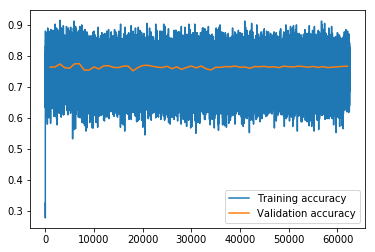

In [10]:
plt.plot(np.array(train_accs)[:,0], np.array(train_accs)[:,1], label='Training accuracy')
plt.plot(np.array(valid_accs)[:,0], np.array(valid_accs)[:,1], label='Validation accuracy')
plt.legend()
plt.show()

# Assignments

1. The code provided uses fixed length sequences. Save your results, change `vary_lengths` to `True`, and run it again. Does the RNN still succeed? What explains the difference?
1. Try and change the model architecture - e.g. number of units or number of layers. How does that affect performance?

# Optional Assignments
1. Compare RNN and LSTM. Replace `torch.nn.RNN` with `torch.nn.LSTM` in order to use an LSTM instead. Compare the results of the LSTM and the RNN. Can you see a difference?
1. Try and **remove teacher forcing**. This will require you to change the data generator `get_random_bits_parity` to use `np.sum` rather than `np.cumsum`. You also need to change some things in the training loop - use the error mesages to guide you.
